In [1]:
import os
os.chdir("..")

from src.data_loader import DatabaseConnection

In [2]:
db_connection = DatabaseConnection(
    ssh_host='www.redesign777.tokyo',
    ssh_port=22,
    ssh_user='rddev',
    ssh_password='rdDev@20240521',
    db_host='localhost',
    db_port=3306,
    db_user='rddev',
    db_password='rdSql@20240521',
    db_name='redesign'
)
db_connection.start_tunnel()

2024-08-30 14:49:18,486| ERROR   | Password is required for key C:\Users\yshim/.ssh\id_rsa


SSHトンネルが 51559 にバインドされました。


In [3]:
# クエリを実行
df_frame = db_connection.execute_query("SELECT * FROM re_m_frame")
df_katashiki = db_connection.execute_query("SELECT * FROM re_m_katashiki")
df_pachinko = db_connection.execute_query("SELECT * FROM re_m_katashikidetailpachinko")
df_slot = db_connection.execute_query("SELECT * FROM re_m_katashikidetailslot")
df_katashiki_frame_relation = db_connection.execute_query("SELECT * FROM re_m_katashikiframerelation")
df_maker = db_connection.execute_query("SELECT * FROM re_m_maker")
df_model_evaluation = db_connection.execute_query("SELECT * FROM re_m_modelevaluation")
df_pachinko_type = db_connection.execute_query("SELECT * FROM re_m_pachinkotype")
df_pachinko_type_detail = db_connection.execute_query("SELECT * FROM re_m_pachinkotypedetail")
# SSHトンネルを閉じる
db_connection.close_tunnel()

SSHトンネルを閉じました。


In [4]:
from src.data_preprocessing import data_preprocessing_operator
import configparser

config = configparser.ConfigParser()
config.read('config.ini')

# start_date :　抽出データ開始日
# end_date : 抽出データ終了日
# openai_api_key : openaiのAPIキー
# use_existing_brand : 既存のブランドデータを使うかどうか
# brand_output_path : 抽出したブランドリストを出力するパス

data_model = data_preprocessing_operator(start_date="2020/01/01 00:00:00",
                                        end_date="2024/08/20 23:59:59",
                                        openai_api_key=config['openai']['api_key'],
                                        use_existing_brand=True,
                                        brand_output_path='brand_lists/brand_list_20200101_20240820.csv')

existing_brand_path = 'brand_lists/brand_list_20200101_20240616.csv'

df = data_model.process( 
                df_frame,
                df_katashiki,
                df_pachinko,
                df_slot,
                df_katashiki_frame_relation,
                df_model_evaluation,
                df_pachinko_type,
                df_pachinko_type_detail, existing_brand_path)

In [5]:
cols = df.columns.tolist()

targets = [
     'Performance',
     'Spec',
     'Content',
     'News',
     'Concept',
     'Period',
     'SaleUnit_eval',
     'Running',
     'Returns',
     'Price_eval']

features = [col for col in cols if col not in targets + ['Name', 'ModelLife', 'ModelLife_category', 'GrossProfit', 'GrossProfit_category', 'KatashikiId', 'Regist_Date', 'Color', 'TypeName', 'TypeName_detail', 'brand_name']]


In [6]:
import pandas as pd

print('特徴量の数: ', len(features))

df = df[df['GrossProfit'] > 0]
df = df[df['ModelLife'] > 0]

# 学習とテストデータの定義
df_train = df[df['Regist_Date'] < df['Regist_Date'].min() + pd.DateOffset(days=365*4 - 90)]
df_test = df[df['Regist_Date'] >= df['Regist_Date'].min() + pd.DateOffset(days=365*4 - 90)]

特徴量の数:  164


In [7]:
def categorize_modellife(x):
    if x >= 0 and x <= 6:
        return 1
    elif x >= 7 and x <= 9:
        return 2
    elif x >= 10 and x <= 13:
        return 3
    elif x >= 14 and x <= 17:
        return 4
    else:
        return 5

def categorize_grossprofit(x):
    if x <= 200000:
        return 1
    elif x > 200000 and x <= 300000:
        return 2
    elif x > 300000 and x <= 400000:
        return 3
    elif x > 400000 and x <= 600000:
        return 4
    elif x > 600000 and x <= 800000:
        return 5
    else:
        return 6

# Poisson損失関数のLGBMを使用

In [9]:
from src.hyperparameters_tuning import model_tuning

mt_gbm = model_tuning(file_path='hyperparameters/best_parameters_profit_lightgbm_poisson.json')

mt_gbm.tune_models(features,
                   ['ModelLife', 'GrossProfit'],
                   df_train,
                   model_kind='lightgbm_regressor_poisson',
                   n_trials=1000,
                   loss='rmse') 

最適化: minimize  rmse
--- ModelLife ---
trial: 363
rmse : 10.656751381545961
ベストパラメータ: {'boosting_type': 'gbdt', 'num_leaves': 49, 'max_depth': 7, 'learning_rate': 0.010010512719802099, 'n_estimators': 126, 'min_child_samples': 45, 'min_child_weight': 0.0342120931341024, 'subsample': 0.6447528298655301, 'colsample_bytree': 0.6000559527457271, 'reg_alpha': 0.9131725527970257, 'reg_lambda': 1.5209628978180223, 'max_bin': 182, 'lambda_l1': 1.1612229387964144, 'lambda_l2': 1.6809208502296524}
--- GrossProfit ---
trial: 647
rmse : 341284.50916949066
ベストパラメータ: {'boosting_type': 'gbdt', 'num_leaves': 27, 'max_depth': 13, 'learning_rate': 0.21911313490399548, 'n_estimators': 355, 'min_child_samples': 24, 'min_child_weight': 0.021439918670541805, 'subsample': 0.5883949679848673, 'colsample_bytree': 0.5461965306698913, 'reg_alpha': 0.42410696917998164, 'reg_lambda': 0.6631813799429345, 'max_bin': 208, 'lambda_l1': 0.16822570725967065, 'lambda_l2': 1.1913945469350675}


In [36]:
from src.modeling import modeling
from src.evaluation import evaluation

# 出力のフォルダ場所
folder = 'output_train/output_20240829'

###############パラメータを読み込んで学習と推論　###############
from src.modeling import modeling
m = modeling(features, targets=['ModelLife', 'GrossProfit'])

# lightgbm
models_profit_gbm = m.load_and_train_all(df_train,
                              param_path='hyperparameters/best_parameters_profit_lightgbm_poisson.json',
                              model_kind='lightgbm_regressor')
df_output_profit_gbm = m.predict_all(models_profit_gbm, df_test)
df_output_profit_gbm_train = m.predict_all(models_profit_gbm, df_train)

In [39]:
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score

for target in ['ModelLife', 'GrossProfit']: # 元のデータにフィッテイング
    func = categorize_modellife if target == 'ModelLife' else categorize_grossprofit
    df_output_profit_gbm[target+'_category' + '_pred'] = df_output_profit_gbm[target+'_pred'].apply(lambda x : func(x))
    df_output_profit_gbm[target+'_category'] = df_output_profit_gbm[target].apply(lambda x : func(x))

    df_output_profit_gbm_train[target+'_category' + '_pred'] = df_output_profit_gbm_train[target+'_pred'].apply(lambda x : func(x))
    df_output_profit_gbm_train[target+'_category'] = df_output_profit_gbm_train[target].apply(lambda x : func(x))
    
    rmse = mean_squared_error(df_output_profit_gbm[target], df_output_profit_gbm[target+ '_pred'], squared=False)
    accuracy = accuracy_score(df_output_profit_gbm[target + '_category'], df_output_profit_gbm[target+'_category' + '_pred'])

    rmse_train = mean_squared_error(df_output_profit_gbm_train[target], df_output_profit_gbm_train[target+ '_pred'], squared=False)
    accuracy_train = accuracy_score(df_output_profit_gbm_train[target + '_category'], df_output_profit_gbm_train[target+'_category' + '_pred'])
    
    print('---------------')
    print('-Train-')
    print(target)
    print('RMSE:', rmse_train)
    print('正解率:', accuracy_train)
    print(df_output_profit_gbm_train[target+ '_category'+'_pred'].value_counts())
    
    print('-Test-')    
    print(target)
    print('RMSE:', rmse)
    print('正解率:', accuracy)
    print(df_output_profit_gbm[target+ '_category'+'_pred'].value_counts())

---------------
-Train-
ModelLife
RMSE: 16.77824252976598
正解率: 0.15897435897435896
ModelLife_category_pred
3    233
5     87
4     70
Name: count, dtype: int64
-Test-
ModelLife
RMSE: 6.983995406333916
正解率: 0.10526315789473684
ModelLife_category_pred
3    42
5     9
4     6
Name: count, dtype: int64
---------------
-Train-
GrossProfit
RMSE: 14462.566545914793
正解率: 0.9461538461538461
GrossProfit_category_pred
1    131
2     90
4     59
6     43
3     42
5     25
Name: count, dtype: int64
-Test-
GrossProfit
RMSE: 266901.6446309191
正解率: 0.38596491228070173
GrossProfit_category_pred
3    18
2    14
1    11
4    10
6     2
5     2
Name: count, dtype: int64


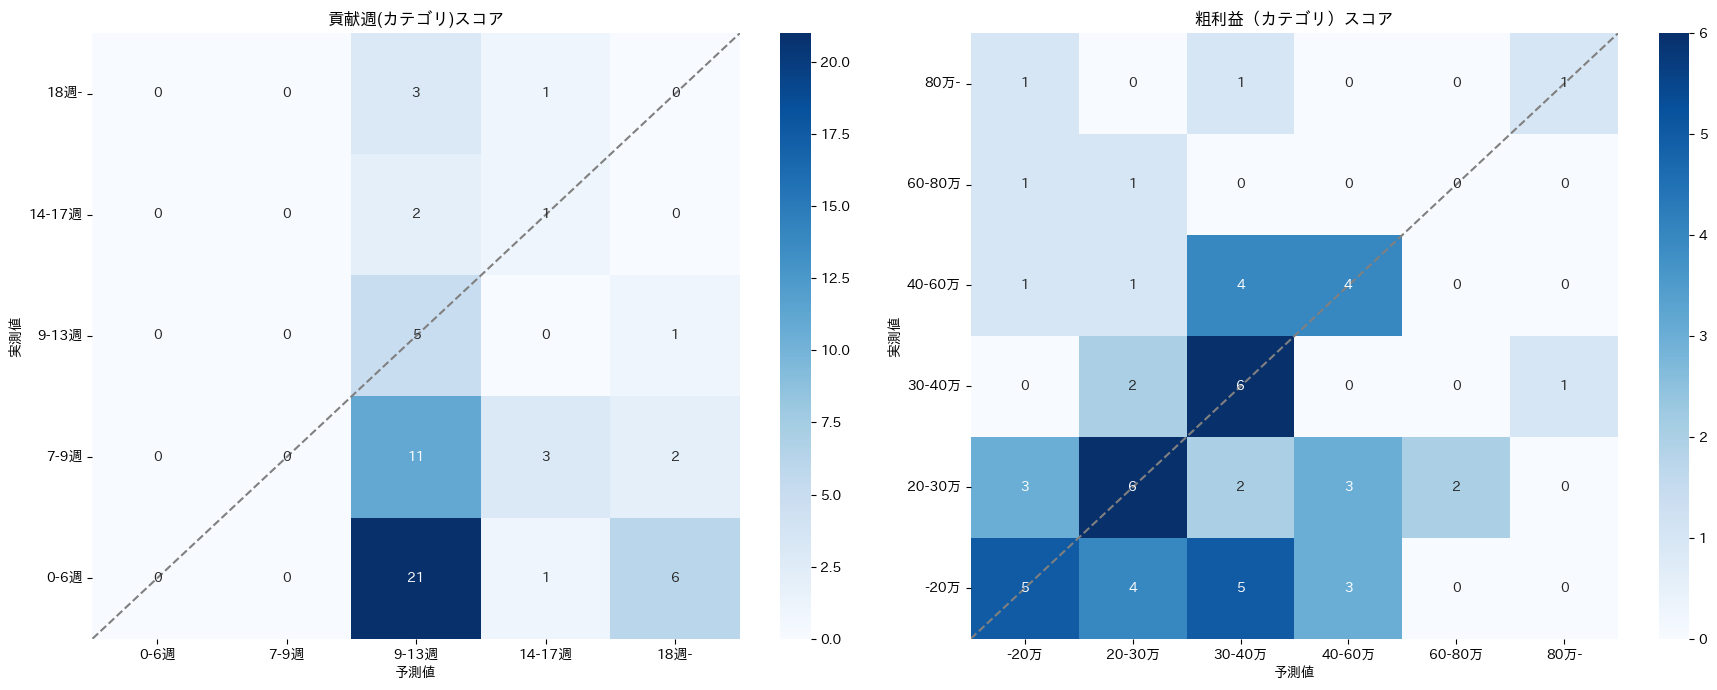

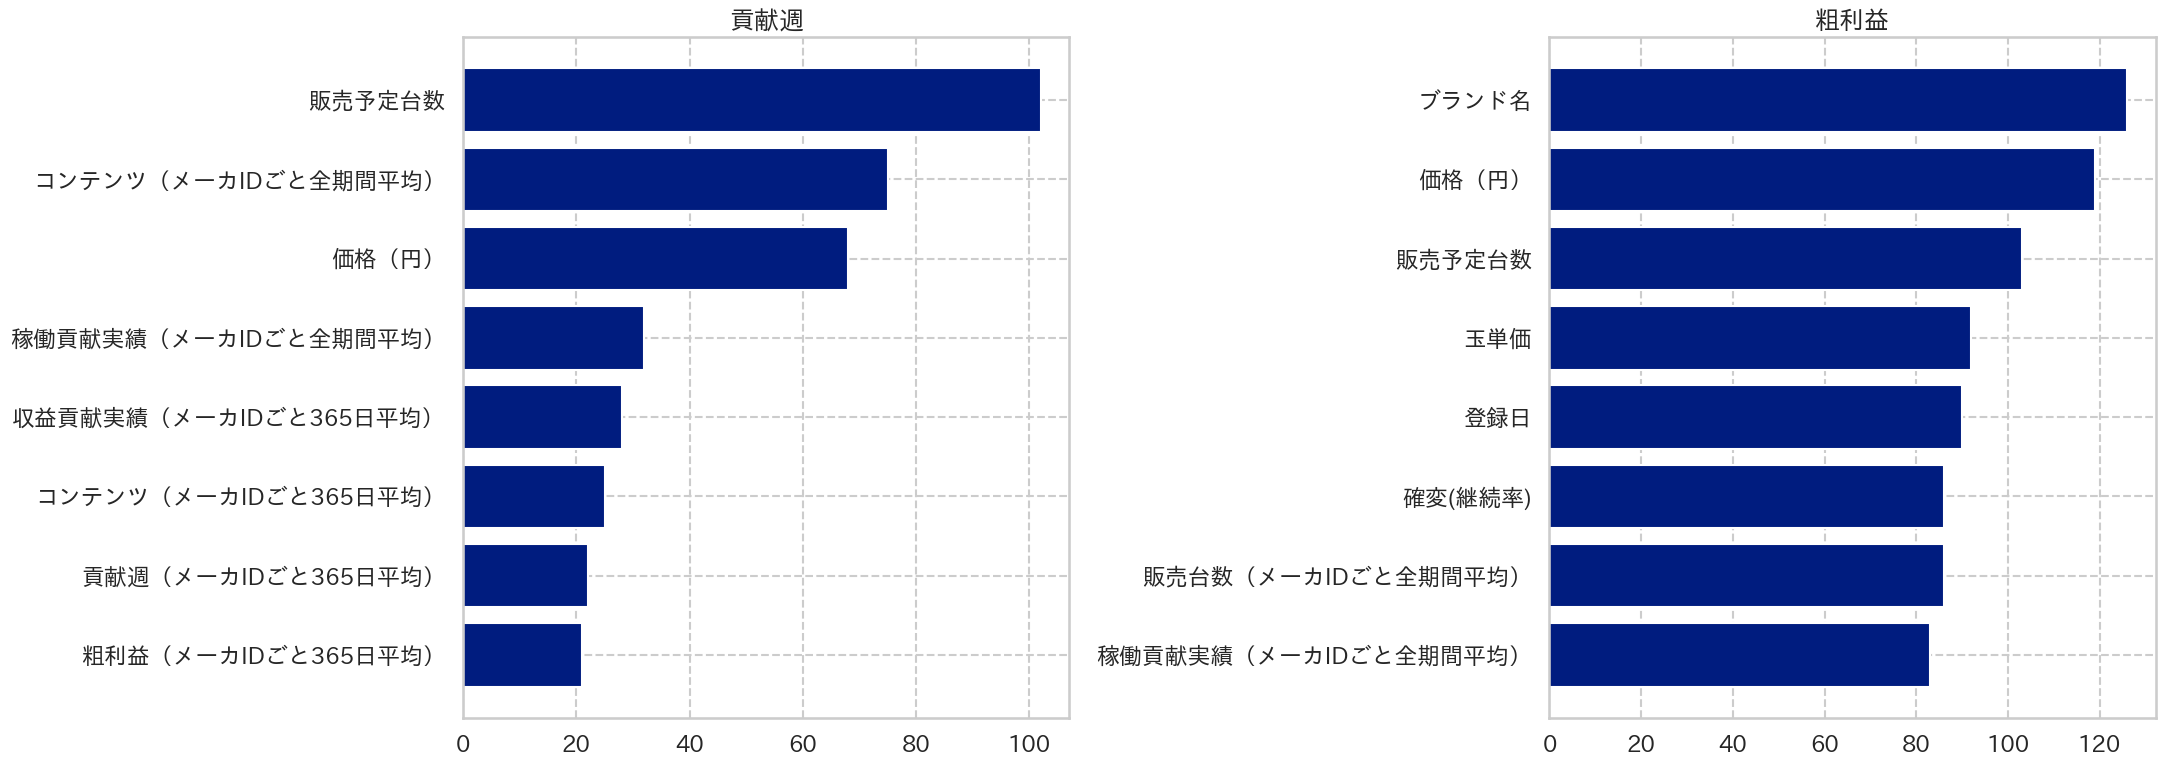

In [40]:
import importlib
import sys
importlib.reload(sys.modules[evaluation.__module__])

from src.evaluation import evaluation

eval = evaluation(None, None)

tick_labels = [['0-6週', '7-9週', '9-13週', '14-17週', '18週-'],
   ['-20万', '20-30万', '30-40万', '40-60万','60-80万', '80万-']]

fig_heatmap = eval.make_multiple_heatmaps(df_output_profit_gbm.copy(), [0, 0], [5, 6], N=[6, 7],
                              targets=['ModelLife_category', 'GrossProfit_category'],
                              fig_N_rows=1, fig_N_cols=2, figsize=(18, 7), label_decimals=0, tick_labels=tick_labels)
fig_importance = eval.plot_feature_importance(models_profit_gbm, ['ModelLife', 'GrossProfit'],
                    features=features, N=8, fig_N_rows=1, fig_N_cols=2, figsize=(22, 8))

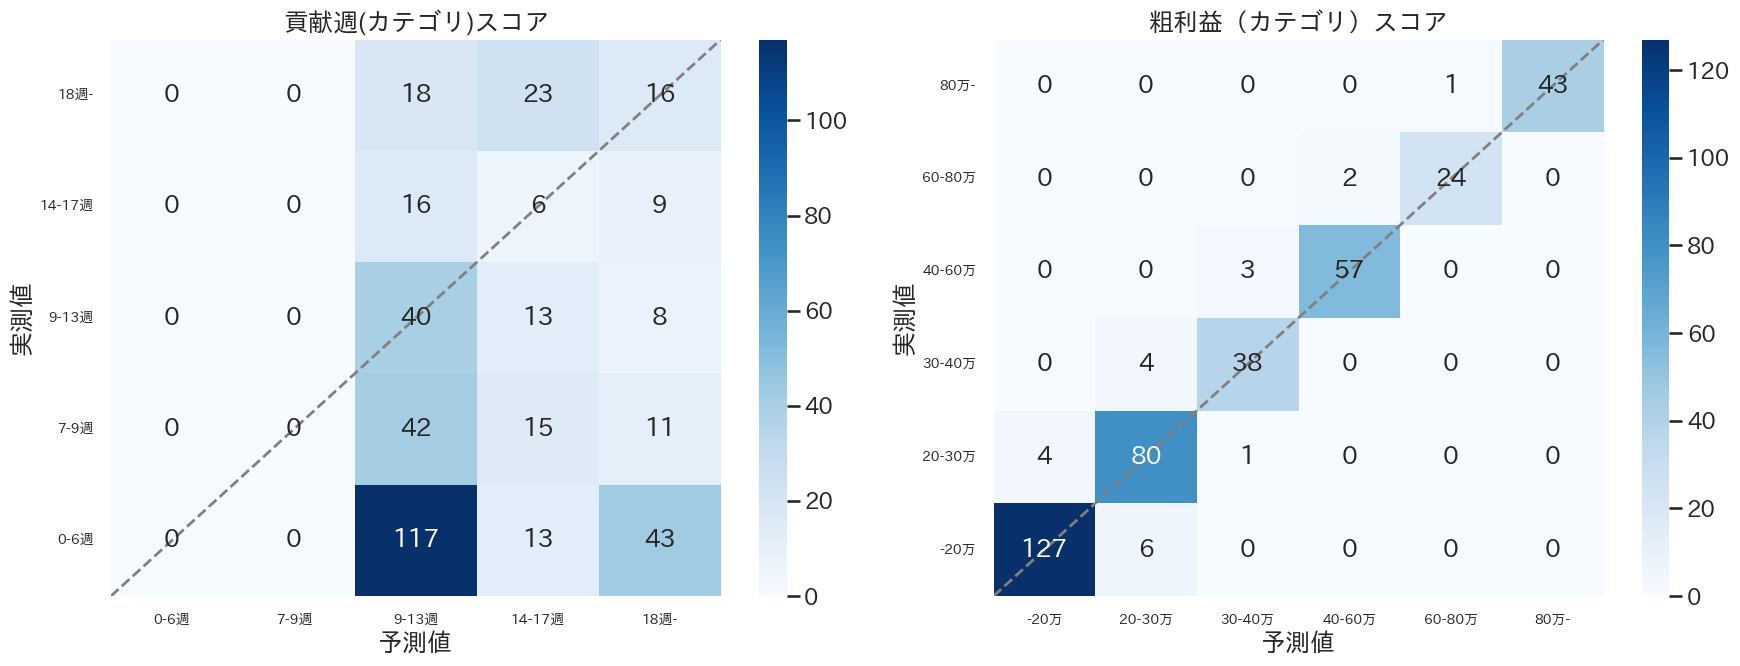

In [41]:
fig_heatmap = eval.make_multiple_heatmaps(df_output_profit_gbm_train.copy(), [0, 0], [5, 6], N=[6, 7],
                              targets=['ModelLife_category', 'GrossProfit_category'],
                              fig_N_rows=1, fig_N_cols=2, figsize=(18, 7), label_decimals=0, tick_labels=tick_labels)

Text(0, 0.5, '実績値')

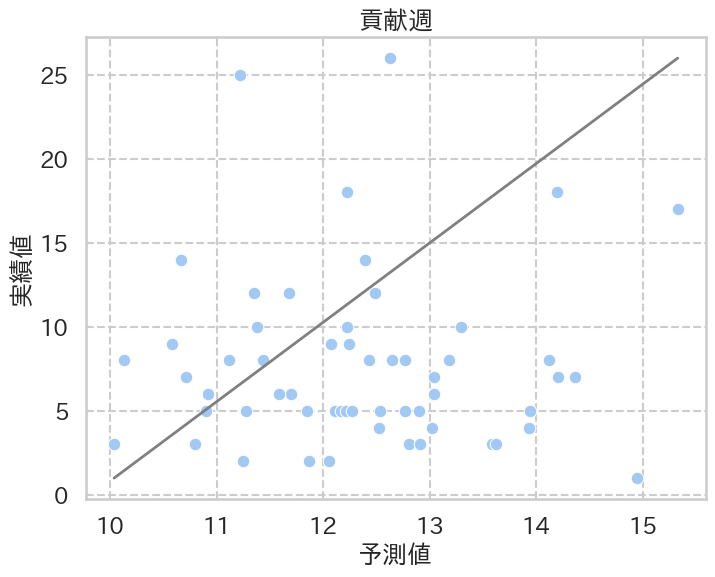

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
sns.set_palette("pastel")

plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_output_profit_gbm['ModelLife_pred'], y=df_output_profit_gbm['ModelLife'],
                data=df_output_profit_gbm)
plt.plot([df_output_profit_gbm['ModelLife_pred'].min(), df_output_profit_gbm['ModelLife_pred'].max()],
         [df_output_profit_gbm['ModelLife'].min(), df_output_profit_gbm['ModelLife'].max()], color='grey')
plt.title('貢献週')
plt.xlabel('予測値')
plt.ylabel('実績値')

(array([      0.,  100000.,  200000.,  300000.,  400000.,  500000.,
         600000.,  700000.,  800000.,  900000., 1000000.]),
 [Text(0.0, 0, '0'),
  Text(100000.0, 0, '100000'),
  Text(200000.0, 0, '200000'),
  Text(300000.0, 0, '300000'),
  Text(400000.0, 0, '400000'),
  Text(500000.0, 0, '500000'),
  Text(600000.0, 0, '600000'),
  Text(700000.0, 0, '700000'),
  Text(800000.0, 0, '800000'),
  Text(900000.0, 0, '900000'),
  Text(1000000.0, 0, '1000000')])

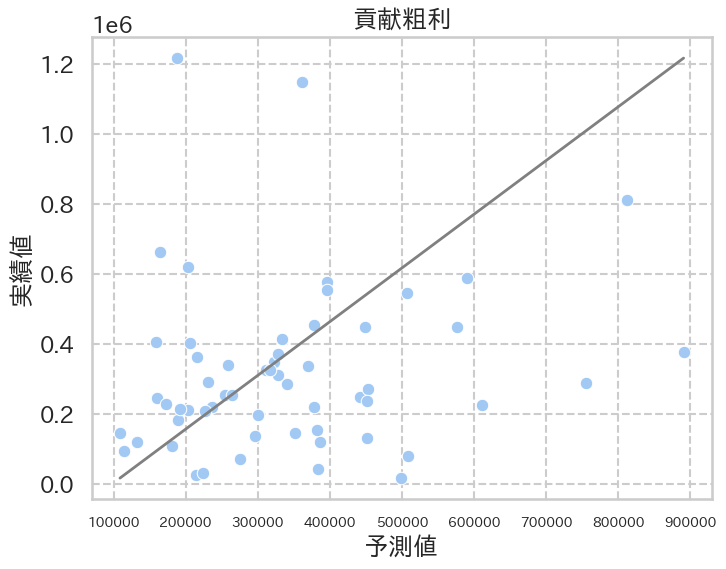

In [69]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_output_profit_gbm['GrossProfit_pred'], y=df_output_profit_gbm['GrossProfit'],
                data=df_output_profit_gbm)
plt.plot([df_output_profit_gbm['GrossProfit_pred'].min(), df_output_profit_gbm['GrossProfit_pred'].max()],
         [df_output_profit_gbm['GrossProfit'].min(), df_output_profit_gbm['GrossProfit'].max()], color='grey')

plt.title('貢献粗利')
plt.xlabel('予測値')
plt.ylabel('実績値')
plt.xticks(fontsize=10)

# 貢献週を時系列でみてみる

In [21]:
df

,KatashikiId,MakerId,Kind,Name,Price,NairanFlag,TenjiFlag,InspectFlag,KakuhenRate1_1,KakuhenRate1_2,...,ModelLife_all_past_mean_per_brand_name,GrossProfit_90days_mean_per_brand_name,GrossProfit_365days_mean_per_brand_name,GrossProfit_all_past_mean_per_brand_name,Color_Encoded,TypeName_Encoded,TypeName_detail_Encoded,brand_name_Encoded,ModelLife_category,GrossProfit_category
0,P2020121508554101,6,0,PAぱちんこAKB48桜LIGHTver．満開モード搭載MA5,499800,0,0,0,46.3,92.6,...,NaN,NaN,NaN,NaN,1.0,6.0,1.0,0.0,3,4
1,S2021080911464501,98,1,S ANEMONE FF,478000,0,0,0,NaN,NaN,...,NaN,NaN,NaN,NaN,-1.0,-1.0,-1.0,1.0,1,1
2,S2021020212072301,18,1,S Angel Beats! XF,480000,0,0,0,NaN,NaN,...,NaN,NaN,NaN,NaN,-1.0,-1.0,-1.0,2.0,4,4
4,P2021040518060201,25,0,PAナナシーSPECIAL 3VV,429000,0,0,0,0.0,0.0,...,NaN,NaN,NaN,NaN,124.0,6.0,1.0,4.0,1,1
5,P2023121216410601,11,0,PAフィーバーパワフル R,439900,0,0,0,100.0,100.0,...,NaN,NaN,NaN,NaN,88.0,6.0,1.0,5.0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520,S2021062315403401,7,1,S麻雀物語4 L2,459000,0,0,0,NaN,NaN,...,NaN,NaN,NaN,NaN,-1.0,-1.0,-1.0,338.0,4,4
521,P2022033112193401,31,0,P麻雀物語4 M1AU1Y,459000,0,0,0,50.8,90.8,...,16.0,NaN,414858.0,414858.0,44.0,4.0,0.0,338.0,1,2
522,S2020111815092001,7,1,SパチスロKING黄門ちゃま L6,449000,0,0,0,NaN,NaN,...,NaN,NaN,NaN,NaN,-1.0,-1.0,-1.0,339.0,1,1
523,P2022053008143501,2,0,P黄門ちゃま8 L9AZ1,459000,0,0,0,50.0,100.0,...,4.0,NaN,NaN,173230.0,87.0,7.0,3.0,339.0,2,2


In [29]:
df_modellife = df[['Regist_Date_year', 'Regist_Date_month', 'ModelLife']].groupby(['Regist_Date_year', 'Regist_Date_month']).mean()['ModelLife'].reset_index()
df_modellife['yyyymm'] = pd.to_datetime(df_modellife['Regist_Date_year'].astype(str) + '/' + df_modellife['Regist_Date_month'].astype(str))

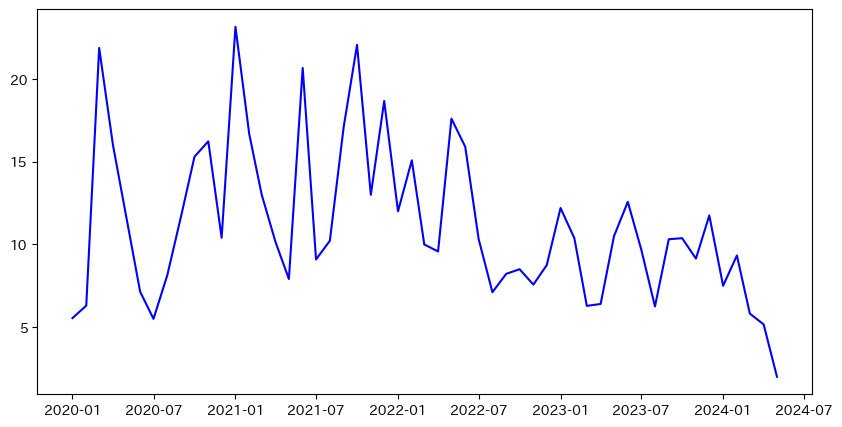

In [32]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df_modellife['yyyymm'], df_modellife['ModelLife'],color='blue')

In [33]:
df_grossprofit = df[['Regist_Date_year', 'Regist_Date_month', 'GrossProfit']].groupby(['Regist_Date_year', 'Regist_Date_month']).mean()['GrossProfit'].reset_index()
df_grossprofit['yyyymm'] = pd.to_datetime(df_grossprofit['Regist_Date_year'].astype(str) + '/' + df_grossprofit['Regist_Date_month'].astype(str))

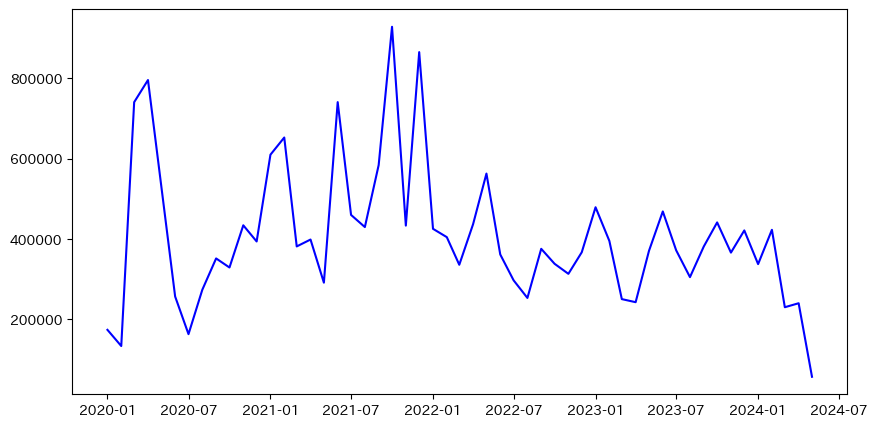

In [34]:

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df_grossprofit['yyyymm'], df_grossprofit['GrossProfit'],color='blue')

# 予測が外れているデータの分析

In [14]:
df_output = pd.concat([df_test[['KatashikiId', 'Regist_Date']], df_output_profit_gbm], axis=1)

In [16]:
df_output['ModelLife_pred_actual_diff'] = df_output['ModelLife_pred'] - df_output['ModelLife']

In [17]:
# 一旦パチンコに絞って分析を行う
df_output

,KatashikiId,Regist_Date,Kind,ModelLife,GrossProfit,ModelLife_pred,GrossProfit_pred,ModelLife_pred_actual_diff
5,P2023121216410601,2023-12-21 08:50:48,0,8.0,212737.0,11.431254,203663.129683,3.431254
13,P2023103109204301,2023-10-31 13:25:41,0,9.0,448512.0,12.242728,576086.834214,3.242728
16,S2024052020194301,2024-05-27 16:45:00,1,3.0,119088.0,12.802361,386710.656204,9.802361
20,P2024020620593401,2024-02-07 21:34:36,0,18.0,810664.0,12.223342,811623.596462,-5.776658
27,P2024030312432501,2024-03-11 13:29:28,0,4.0,196539.0,12.522378,300933.686982,8.522378
32,S2023112715345801,2023-11-28 11:53:22,1,14.0,455158.0,12.396015,378513.854016,-1.603985
33,P2023120513404701,2023-12-07 10:27:47,0,10.0,378021.0,13.289004,890576.289189,3.289004
35,P2023120514100501,2023-12-11 14:48:21,0,10.0,588735.0,11.378195,590512.593754,1.378195
54,S2024012617164601,2024-02-07 12:56:16,1,9.0,403563.0,10.574642,205571.105334,1.574642
55,P2024032516115901,2024-04-03 23:19:45,0,10.0,545581.0,12.218823,507231.050973,2.218823


In [20]:
pd.merge(df_output, df_pachinko[['KatashikiId', 'Regist_Date', 'Update_Date']],
         on='KatashikiId', suffixes=('', '_detail'))

,KatashikiId,Regist_Date,Kind,ModelLife,GrossProfit,ModelLife_pred,GrossProfit_pred,ModelLife_pred_actual_diff,Regist_Date_detail,Update_Date
0,P2023121216410601,2023-12-21 08:50:48,0,8.0,212737.0,11.431254,203663.129683,3.431254,2023-12-12 16:41:06,2024-05-10 10:25:52
1,P2023103109204301,2023-10-31 13:25:41,0,9.0,448512.0,12.242728,576086.834214,3.242728,2023-10-31 09:20:43,2024-06-03 14:17:33
2,P2024020620593401,2024-02-07 21:34:36,0,18.0,810664.0,12.223342,811623.596462,-5.776658,2024-02-06 20:59:34,2024-08-28 13:37:06
3,P2024030312432501,2024-03-11 13:29:28,0,4.0,196539.0,12.522378,300933.686982,8.522378,2024-03-03 12:43:25,2024-06-07 14:13:54
4,P2023120513404701,2023-12-07 10:27:47,0,10.0,378021.0,13.289004,890576.289189,3.289004,2023-12-05 13:40:47,2024-05-15 12:56:37
5,P2023120514100501,2023-12-11 14:48:21,0,10.0,588735.0,11.378195,590512.593754,1.378195,2023-12-05 14:10:05,2024-05-15 12:53:29
6,P2024032516115901,2024-04-03 23:19:45,0,10.0,545581.0,12.218823,507231.050973,2.218823,2024-03-25 16:11:59,2024-08-14 14:23:51
7,P2023121915345801,2024-01-05 15:58:35,0,14.0,663410.0,10.664080,164400.195597,-3.335920,2023-12-19 15:34:58,2024-06-12 11:49:21
8,P2024012913553501,2024-02-08 10:56:45,0,9.0,414720.0,12.076098,333121.679196,3.076098,2024-01-29 13:55:35,2024-06-12 11:46:55
9,P2023110710341801,2023-11-14 16:04:07,0,25.0,1147000.0,11.213531,361782.230439,-13.786469,2023-11-07 10:34:18,2024-07-17 14:08:08
